## Simulation of Gaussian-Schell model beam incident on dual microlens arrays (MLA's) for laser beam array generation.

In [1]:
%pylab
%matplotlib inline
import SimMLA.fftpack as simfft
import SimMLA.grids   as grids
import SimMLA.fields  as fields

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


The grid artifact from coherent illumination on the dual MLA illuminators can be minimized or eliminated by introducing a rotating diffuser into the setup before the MLA's. This effectively decreases the spatial coherence of the beam and broadens the peaks in the grid until the overall illumination is flat.

We can introduce the effects of the diffuser into the simulations by simulating a partially coherent beam. To do this, we'll simulate a Gaussian Schell model beam using a technique described in [Xiao and Voelz, "Wave optics simulation approach for partial spatially coherent beams," Opt. Express 14, 6986-6992 (2006)](https://www.osapublishing.org/oe/abstract.cfm?uri=oe-14-16-6986).

## Build the dual MLA illuminator

In [2]:
numLenslets = 21    # Must be odd; corresponds to the number of lenslets in one dimension
lensletSize = 500   # microns
focalLength = 13700 # microns

wavelength  = 0.642 # microns

subgridSize  = 10001                     # Number of grid (or lattice) sites for a single lenslet
physicalSize = numLenslets * lensletSize # The full extent of the MLA

# dim = 1 makes the grid 1D
grid = grids.GridArray(numLenslets, subgridSize, physicalSize, wavelength, focalLength, dim = 1)

To create a *single* realization of a GSM beam, we'll use one of the `fields` routines in SimMLA.

In [24]:
Z0              = 376.73 # Impedance of free space, Ohms
power           = 100  # mW
beamStd         = 1000 # microns
coherenceLength = 500  # microns
fieldAmp = np.sqrt(power / 1000 * Z0 / beamStd / np.sqrt(np.pi)) # Factor of 1000 converts from mW to W

beam     = fields.GSMBeamRealization(fieldAmp, beamStd, coherenceLength)

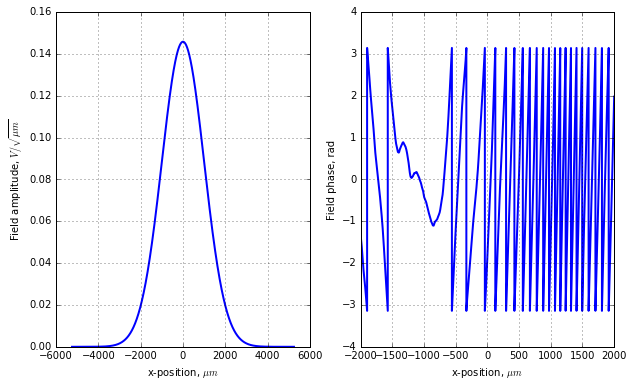

In [25]:
fig, (ax0, ax1) = plt.subplots(nrows = 1, ncols = 2, sharey = False, figsize = (10, 6))
ax0.plot(grid.px, np.abs(beam(grid.px)), linewidth = 2)
ax0.set_xlabel(r'x-position, $\mu m$')
ax0.set_ylabel(r'Field amplitude, $V / \sqrt{\mu m}$')
ax1.set_xlim((-2000, 2000))
ax0.grid(True)

ax1.plot(grid.px, np.angle(beam(grid.px)), linewidth = 2)
ax1.set_xlabel(r'x-position, $\mu m$')
ax1.set_ylabel(r'Field phase, rad')
ax1.set_xlim((-2000, 2000))
ax1.grid(True)
plt.show()

As you can see, the phase varies smoothly and randomly. Let's compute the autocorrelation of the phasor of the field to see what it's correlation length is.

In [26]:
# Compute coherence length here

In [5]:
from scipy.integrate import simps
integratedPower = simps(beam(grid.px)**2, grid.px) * 1000 / Z0

print('The total power in the beam is: {0:.4f}'.format(integratedPower))
print('The input power in the beam is: {0:.4f}'.format(power))

The total power in the beam is: 100.0000
The input power in the beam is: 100.0000


Since both of these checks pass, we are likely accurately computing the beam waist in SimMLA.

## Propagate the Gaussian through the illuminator
Propagating this beam through the MLA-based illuminator is the same as for the plane wave case. First we find the field immediately after the second MLA.

In [6]:
%%time
# Compute the interpolated fields
# Linear interpolation is used for speed
interpMag, interpPhase = simfft.fftSubgrid(beam, grid)

fObj        = 3300 # microns
newGridSize = subgridSize * numLenslets # microns

# Upsample grid by an odd factor to reduce rippling
newGrid = grids.Grid(5*newGridSize, 5*physicalSize, wavelength, fObj, dim = 1)
field   = np.zeros(newGrid.gridSize)

# For each interpolated magnitude and phase corresponding to a lenslet
# 1) Compute the full complex field
# 2) Sum it with the other complex fields
for currMag, currPhase in zip(interpMag, interpPhase):
    fieldMag   = currMag(newGrid.px)
    fieldPhase = currPhase(newGrid.px)
    
    currField = fieldMag * np.exp(1j * fieldPhase)
    field     = field + currField

CPU times: user 3min 16s, sys: 13 s, total: 3min 29s
Wall time: 3min 29s


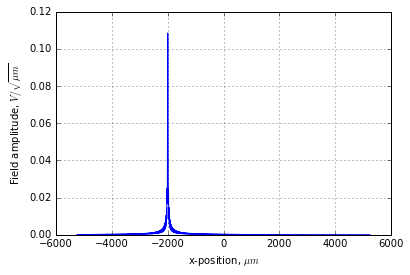

In [7]:
# Check that we've successfully computed the Fourier transform of a lenslet.
m = 6 # lenslet index, integers between [0, numLenslets - 1]
plt.plot(grid.px, np.abs(interpMag[m](grid.px) * np.exp(1j * interpPhase[m](grid.px))))
plt.xlabel(r'x-position, $\mu m$')
plt.ylabel(r'Field amplitude, $V / \sqrt{\mu m}$')
plt.grid(True)
plt.show()

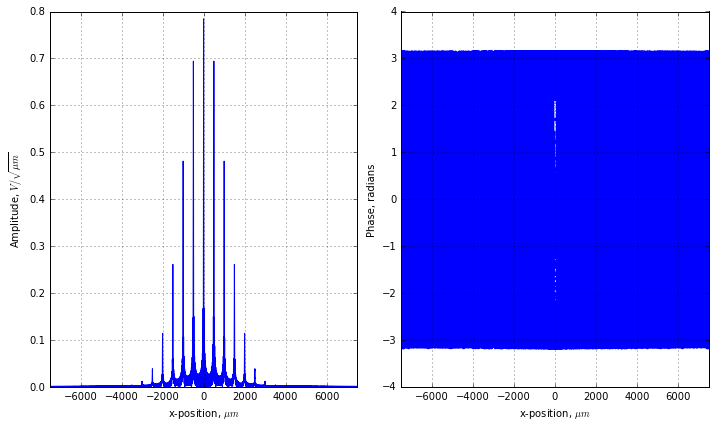

In [8]:
# Plot the field immediately after the second MLA
fig, (ax0, ax1) = plt.subplots(nrows = 1,
                               ncols = 2,
                               sharex = True,
                               sharey = False,
                               figsize = (10,6))

ax0.plot(newGrid.px, np.abs(field))
ax0.set_xlim((-7500, 7500))
ax0.set_xlabel(r'x-position, $\mu m$')
ax0.set_ylabel(r'Amplitude, $V / \sqrt{\mu m}$')
ax0.grid()

ax1.plot(newGrid.px, np.angle(field), '.')
ax1.set_xlabel(r'x-position, $\mu m$')
ax1.set_ylabel('Phase, radians')
ax1.grid()

plt.tight_layout()
plt.show()

In [9]:
# Is power still conserved?
# No scaling factor is necessary because the angular spectrum was only shifted in phase.
powerBFPIn = simps(np.abs(field)**2, newGrid.px) / Z0 * 1000
print('Power before the aperture in the BFP: {0:.4f} mW'.format(powerBFPIn))

Power before the aperture in the BFP: 101.9808 mW


Now that we have the field after the second MLA, we propagate it to the objective's back aperture, truncate it, and finally compute the field on the sample.

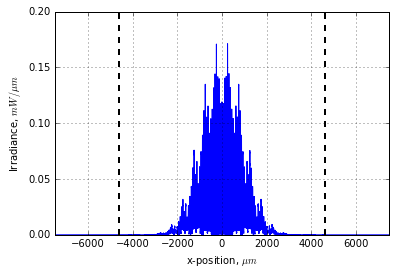

In [10]:
propDistance = 20000 # Approximate distance between second MLA and objective's back focal plane, microns
u2 = simfft.fftPropagate(field, newGrid, 20000)

bfpDiam = 2 * 1.4 * 3300 # BFP diameter, 2 * NA * f_OBJ
yMax = 0.2
u2Prime = u2
u2Prime[np.logical_or(newGrid.px < -bfpDiam / 2, newGrid.px > bfpDiam / 2)] = 0.0

# Plot the field in the objective's back focal plane without the aperture
plt.plot(newGrid.px, np.abs(u2Prime)**2 / Z0 * 1000)
plt.plot([-bfpDiam / 2, -bfpDiam / 2], [0, yMax], '--k', linewidth = 2, label = 'Back aperture')
plt.plot([bfpDiam / 2, bfpDiam / 2],   [0, yMax], '--k', linewidth = 2)
plt.xlim((-7500, 7500))
plt.ylim((0, yMax))
plt.xlabel(r'x-position, $\mu m$')
plt.ylabel(r'Irradiance, $mW / \mu m$')
plt.grid(True)
plt.show()

In [11]:
# Is power still conserved?
# No scaling factor is necessary because the angular spectrum was only shifted in phase.
powerBFPIn = simps(np.abs(u2)**2, newGrid.px) / Z0 * 1000
print('Power before the aperture in the BFP: {0:.4f} mW'.format(powerBFPIn))

Power before the aperture in the BFP: 101.2354 mW


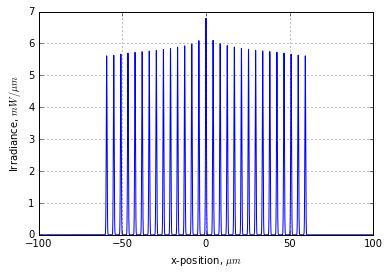

Power delivered to sample: 101.2354 mW


In [12]:
# Sample plane irradiance including limiting aperture in the BFP
scalingFactor = newGrid.physicalSize / (newGrid.gridSize - 1) / np.sqrt(newGrid.wavelength * newGrid.focalLength)
F             = scalingFactor * np.fft.fftshift(np.fft.fft(np.fft.ifftshift(u2Prime)))

plt.plot(newGrid.pX, np.abs(F)**2 / Z0 * 1000)
plt.xlim((-100, 100))
plt.xlabel(r'x-position, $\mu m$')
plt.ylabel(r'Irradiance, $mW / \mu m$')
plt.grid(True)
plt.show()

powerSample = simps(np.abs(F)**2, newGrid.pX) / Z0 * 1000
print('Power delivered to sample: {0:.4f} mW'.format(powerSample))